In [3]:
from dataset_utils.voc.preprocessing import letterbox_image_padded
from dataset_utils.voc.eval import evaluate_dataset, evaluate_image, flag_induced_tp, evaluate_dataset_with_builtin, evaluate_dataset_with_torch
from misc_utils.visualization import visualize_detections, get_gt_bboxes, graph_aps, shiftedColorMap
from models.frcnn import FRCNN
from models.ssd import SSD300
from PIL import Image
from tensorflow.keras import backend as K
from tog.attacks import *
from tqdm import tqdm
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
%matplotlib inline
%load_ext autoreload
%autoreload 2
K.clear_session()

weights = 'model_files/FRCNN.pth'  # TODO: Change this path to the victim model's weights
#weights = 'model_files/SSD300.h5'

detector = FRCNN().cuda(device=0).load(weights)
#detector = SSD300(weights=weights)

eps = 8 / 255.       # Hyperparameter: epsilon in L-inf norm
eps_iter = 2 / 255.  # Hyperparameter: attack learning rate
n_iter = 10          # Hyperparameter: number of attack iterations
path = "dataset/VOCdevkit/VOC2007/JPEGImages/"

np.random.seed(42)

# scores = evaluate_dataset(detector, path, attack=None)
# print("(benign) mAP is:", scores["map"])

# scores = evaluate_dataset(detector, path, attack=tog_attention, attack_params={"n_iter": n_iter, "eps": eps, "eps_iter":eps_iter})
# print("(attention) mAP is:", scores["map"])

# scores = evaluate_dataset(detector, path, attack=tog_untargeted, attack_params={"n_iter": n_iter, "eps": eps, "eps_iter":eps_iter})
# print("(untargeted) mAP is:", scores["map"])

/storage/ice1/5/9/zyahn3/TOG_plus/frcnn_utils/utils/nms/non_maximum_suppression.py:9: UserWarning: 
    the python code for non_maximum_suppression is about 2x slow
    It is strongly recommended to build cython code: 
    `cd model/utils/nms/; python3 build.py build_ext --inplace
  warnings.warn('''
2024-09-30 11:12:20.721751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 11:12:21.118447: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 11:12:21.366362: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 11:12:22.435414: I tensorflow/core/platform/cpu_feat

In [ ]:
#Create a mini version of VOC with 25 of each class represented

# import shutil
# new_dir = "dataset/MiniVOC/"
# for file_path in os.listdir("dataset/VOCdevkit/VOC2007/ImageSets/Main"):
#     count = 0
#     f = open("dataset/VOCdevkit/VOC2007/ImageSets/Main/" + file_path, 'r')
#     for line in f:
#         line = line.strip("\n").split(" ")
#         imnum = line[0]
#         status = line[-1]
#         if status == "1":
#             shutil.copyfile("dataset/VOCdevkit/VOC2007/JPEGImages/" + imnum + ".jpg", "dataset/MiniVOC/" + imnum + ".jpg")
#             print("Now have", count, file_path, "from", imnum)
#             count += 1
#         if count == 25:
#             break
#     f.close()
        

In [2]:
#im_path = 'dataset/AttackFails/FailImages/'
mini_path = 'dataset/MiniVOC/'
im_path = 'dataset/VOCdevkit/VOC2007/JPEGImages/'
annot_path = 'dataset/VOCdevkit/VOC2007/Annotations/'

out = evaluate_dataset(detector, im_path, annot_path, num_examples=50, attack=None)
print(out)
#flag_induced_tp(detector, im_path, annot_path, num_examples=20, attack=tog_untargeted)

100%|██████████| 50/50 [00:10<00:00,  4.82it/s]

{'aps': array([       nan, 0.7       , 0.72      , 1.        ,        nan,
       0.75      , 0.73333333,        nan, 0.325     , 0.45      ,
       0.5       , 0.63333333, 0.73333333, 0.9       , 0.72580645,
       0.63333333, 0.175     , 0.6       , 0.9       , 0.68333333]), 'map': 0.6566160657811513}



/storage/ice1/5/9/zyahn3/TOG_plus/dataset_utils/eval.py:239: RuntimeWarning: invalid value encountered in scalar divide
  return (1. * a[0]) / (a[0] + a[1])
/storage/ice1/5/9/zyahn3/TOG_plus/dataset_utils/eval.py:243: RuntimeWarning: Mean of empty slice
  aps = np.nanmean(precs, axis=1)


<Figure size 640x480 with 0 Axes>

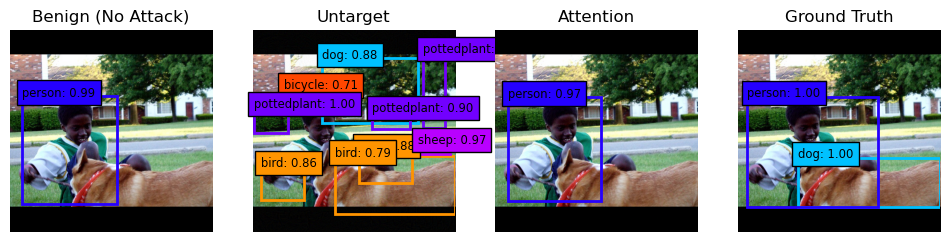

In [4]:
fpath = 'dataset/VOCdevkit/VOC2007/JPEGImages/'
annot_path = 'dataset/VOCdevkit/VOC2007/Annotations/'
im = "000539.jpg"

input_img = Image.open(fpath + im)
x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)

x_adv = tog_untargeted(detector, x_query)
detections_adv = detector.detect(x_adv, conf_threshold=detector.confidence_thresh_default)

x_attn = tog_attention(detector, x_query)
detections_attn = detector.detect(x_attn, conf_threshold=detector.confidence_thresh_default)

visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'Untarget': (x_adv, detections_adv, detector.model_img_size, detector.classes),
                      'Attention': (x_attn, detections_attn, detector.model_img_size, detector.classes),
                      'Ground Truth': (x_query, get_gt_bboxes(annot_path, im, x_meta), detector.model_img_size, detector.classes)}
                    )
evaluate_image(detector, fpath, annot_path, im, attack=None)
None


In [2]:
# Makes a figure that shows the perturbation, the gradient on the perturbation, 
# the sign of the gradient, and the distribution of pixel values
def visualize_perts(path):
    n_iter=10
    eps=8/255.
    eps_iter=4/255.
    
    input_img = Image.open(path)
    x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
    detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)
    
    x_adv_vanish = tog_vanishing(detector, x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)
    detections_adv_vanish = detector.detect(x_adv_vanish, conf_threshold=detector.confidence_thresh_default)
    pert_vanish = x_query - x_adv_vanish
    
    x_adv_fab = tog_fabrication(detector, x_query, eps=eps, eps_iter=eps_iter)
    detections_adv_fab = detector.detect(x_adv_fab, conf_threshold=detector.confidence_thresh_default)
    pert_fab = x_query - x_adv_fab
    
    x_adv_untarget = tog_untargeted(detector, x_query, eps=eps, eps_iter=eps_iter)
    detections_adv_untarget = detector.detect(x_adv_untarget, conf_threshold=detector.confidence_thresh_default)
    pert_untarget = x_query - x_adv_untarget
    
    visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                         'Vanishing': (x_adv_vanish, detections_adv_vanish, detector.model_img_size, detector.classes),
                         'Fabrication': (x_adv_fab, detections_adv_fab, detector.model_img_size, detector.classes),
                         'Untargeted': (x_adv_untarget, detections_adv_untarget, detector.model_img_size, detector.classes)})
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    for a in ax.flat:
        a.set_axis_off()
    ax[0].matshow(pert_vanish.squeeze()[:, :, 0])
    ax[0].set_title("Vanishing")
    ax[1].matshow(pert_fab.squeeze()[:, :, 0])
    ax[1].set_title("Fabrication")
    ax[2].matshow(pert_untarget.squeeze()[:, :, 0])
    ax[2].set_title("Untargeted")
    plt.show()
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
#     for a in ax.flat:
#         a.set_axis_off()
    ax[0].hist(pert_vanish.flatten(), bins=50)
    ax[0].set_title("Vanishing")
    ax[1].hist(pert_fab.flatten(), bins=50)
    ax[1].set_title("Fabrication")
    ax[2].hist(pert_untarget.flatten(), bins=50)
    ax[2].set_title("Untargeted")
    plt.show()
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    for a in ax.flat:
        a.set_axis_off()
    ax[0].matshow(pert_vanish.squeeze()[:, :, 0] - pert_fab.squeeze()[:, :, 0])
    ax[0].set_title("Vanishing - Fabrication")
    ax[1].matshow(pert_fab.squeeze()[:, :, 0] - pert_untarget.squeeze()[:, :, 0])
    ax[1].set_title("Fabrication - Untargeted")
    ax[2].matshow(pert_untarget.squeeze()[:, :, 0] - pert_vanish.squeeze()[:, :, 0])
    ax[2].set_title("Untargeted - Vanishing")
    plt.show()
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
#     for a in ax.flat:
#         a.set_axis_off()
    ax[0].hist((pert_vanish - pert_fab).flatten(), bins=50)
    ax[0].set_title("Vanishing")
    ax[1].hist((pert_fab - pert_untarget).flatten(), bins=50)
    ax[1].set_title("Fabrication")
    ax[2].hist((pert_untarget - pert_vanish).flatten(), bins=50)
    ax[2].set_title("Untargeted")
    plt.show()

# Calls visualize_pert on each iteration of the attack to view how it progresses    
def visualize_pert_stages(path):
    n_iter=10
    eps=8/255.
    eps_iter=1/255.
    
    img_path = 'dataset/VOCdevkit/VOC2007/JPEGImages/'
    annot_path = 'dataset/VOCdevkit/VOC2007/Annotations/'

    input_img = Image.open(img_path + path)
    x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
    detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)
    
    x_adv_untarget, etas, grads = tog_untargeted_viz(detector, x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)
    detections_adv_untarget = detector.detect(x_adv_untarget, conf_threshold=detector.confidence_thresh_default)
    
    visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                        'Ground Truth': (x_query, get_gt_bboxes(annot_path, path, x_meta), detector.model_img_size, detector.classes),
                          'Untargeted': (x_adv_untarget, detections_adv_untarget, detector.model_img_size, detector.classes)})
    
    # normalize grads to make them easier to see
    grads_norm = (grads - np.min(grads)) / (np.max(grads) - np.min(grads))
    etas_norm = (etas - np.min(etas)) / (np.max(etas) - np.min(etas))
    
    fig, ax = plt.subplots(nrows=n_iter, ncols=4, figsize=(12, n_iter*3+8))
    
    for i in range(n_iter):
#         if i == n_iter - 1:
#             ax[i][0].matshow(etas[i].squeeze()[:, :, 0])
#             ax[i][1].matshow(np.zeros(etas_norm[i].squeeze()[:, :, 0].shape))
#             ax[i][2].matshow(np.zeros(etas_norm[i].squeeze()[:, :, 0].shape))
#             ax[i][3].hist(grads[i].flatten(), bins=100)
#         else:
        #ax[i].matshow(etas[i].squeeze()[:, :, 0])
        ax[i][0].imshow(etas[i].squeeze(), cmap=shiftedColorMap(matplotlib.cm.coolwarm, np.min(etas[i]), np.median(etas[i]), np.max(etas[i])))
        ax[i][1].matshow(grads_norm[i].squeeze()[:, :, 0])
        ax[i][2].matshow(np.sign(grads[i].squeeze()[:, :, 0]))
        ax[i][3].hist(grads[i].flatten(), bins=100)
#             ax[i].set_title(str(i))
#             ax[i,:].set_axis_off()
        ax[i][0].set_title("Iter " + str(i+1) + ": Perturb.")
        ax[i][1].set_title("Norm. Grad")
        ax[i][2].set_title("Sign Grad")
        ax[i][3].set_title("Dist.of Grad")
  
    plt.show()

from matplotlib.colors import LinearSegmentedColormap
from scipy import stats as st
    
def visualize_attention_stages(path):
    n_iter=10
    eps=8/255.
    eps_iter=1/255.
    
    img_path = 'dataset/VOCdevkit/VOC2007/JPEGImages/'
    annot_path = 'dataset/VOCdevkit/VOC2007/Annotations/'

    input_img = Image.open(img_path + path)
    x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
    detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)
    
    x_adv_attn, etas, eta_grads, map_grads, maps = tog_attention(detector, x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter, vis=True)
    detections_adv_attn = detector.detect(x_adv_attn, conf_threshold=detector.confidence_thresh_default)
    
    visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                        'Ground Truth': (x_query, get_gt_bboxes(annot_path, path, x_meta), detector.model_img_size, detector.classes),
                          'Attention': (x_adv_attn, detections_adv_attn, detector.model_img_size, detector.classes)})
    
    # normalize grads to make them easier to see
    perts = np.multiply(etas, maps)
    perts_norm = [(grad - np.min(grad)) / (np.max(grad) - np.min(grad)) for grad in perts]
    perts_norm = [np.clip(1 - np.abs(pert - np.median(pert)), 0, 1) for pert in perts_norm]
    
    eta_grads_norm = [(grad - np.min(grad)) / (np.max(grad)-np.min(grad)) for grad in eta_grads]
    eta_grads_norm = [np.clip(1 - 5*np.abs(grad - np.median(grad)), 0, 1) for grad in eta_grads_norm]
    
    map_grads_norm = [(grad - np.min(grad)) / (np.max(grad)-np.min(grad)) for grad in map_grads]
    map_grads_norm = [np.clip(1 - 5*np.abs(grad - np.median(grad)), 0, 1) for grad in map_grads_norm]
    
    etas_norm = [(eta - np.min(eta)) / (np.max(eta)-np.min(eta)) for eta in etas]
    etas_norm = [np.clip(1 - np.abs(eta - np.median(eta)), 0, 1) for eta in etas_norm]
    
    maps_norm = [(m - np.min(m)) / (np.max(m)-np.min(m)) for m in maps]
    maps_norm = [np.clip(1 - np.abs(m - np.median(m)), 0, 1) for m in maps_norm]
    
    fig, ax = plt.subplots(nrows=n_iter, ncols=5, figsize=(15, n_iter*3+8))

    for i in range(n_iter):
#         if i == n_iter - 1:
#             ax[i][0].matshow(etas[i].squeeze()[:, :, 0])
#             ax[i][1].matshow(np.zeros(etas_norm[i].squeeze()[:, :, 0].shape))
#             ax[i][2].matshow(np.zeros(etas_norm[i].squeeze()[:, :, 0].shape))
#             ax[i][3].hist(grads[i].flatten(), bins=100)
#         else:
        #ax[i].matshow(etas[i].squeeze()[:, :, 0])
        ax[i][0].matshow(perts_norm[i].squeeze()[:, :, 0], cmap=coolwarm)
        ax[i][1].matshow(eta_grads_norm[i].squeeze()[:, :, 0], cmap=coolwarm)
        ax[i][2].matshow(maps_norm[i].squeeze()[:, :, 0], cmap=coolwarm)
        ax[i][3].matshow(map_grads_norm[i].squeeze()[:, :, 0], cmap=coolwarm)
        ax[i][4].hist(maps[i].flatten(), bins=100)
#             ax[i].set_title(str(i))
#             ax[i,:].set_axis_off()
        ax[i][0].set_title("After Iter " + str(i+1) + ": Perturb.")
        ax[i][1].set_title("Eta. Grad")
        ax[i][2].set_title("Attn. Map")
        ax[i][3].set_title("Attn. Grad")
        ax[i][4].set_title("Dist.of Map")
        ax[i][4].set_yscale('log')
    plt.show()

In [31]:
visualize_attention_stages("000539.jpg")
#visualize_pert_stages("000539.jpg")


NameError: name 'visualize_attention_stages' is not defined

<Figure size 640x480 with 0 Axes>

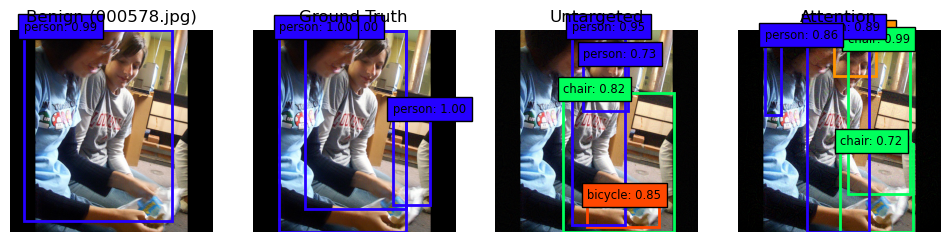

/storage/ice1/5/9/zyahn3/TOG_plus/frcnn_utils/utils/bbox_tools.py:183: RuntimeWarning: invalid value encountered in divide
  return area_i / (area_a[:, None] + area_b - area_i)
/storage/ice1/5/9/zyahn3/TOG_plus/frcnn_utils/utils/bbox_tools.py:138: RuntimeWarning: divide by zero encountered in log
  dh = xp.log(base_height / height)
/storage/ice1/5/9/zyahn3/TOG_plus/frcnn_utils/utils/bbox_tools.py:139: RuntimeWarning: divide by zero encountered in log
  dw = xp.log(base_width / width)


<Figure size 640x480 with 0 Axes>

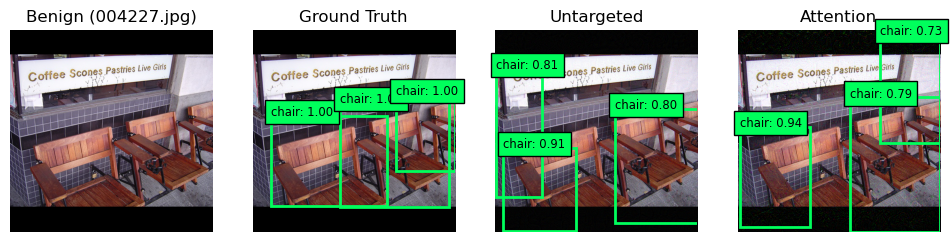

<Figure size 640x480 with 0 Axes>

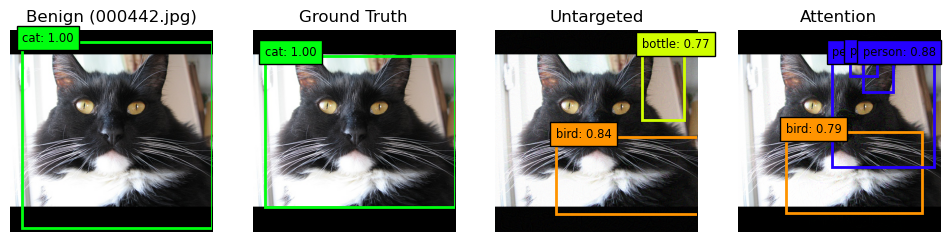

<Figure size 640x480 with 0 Axes>

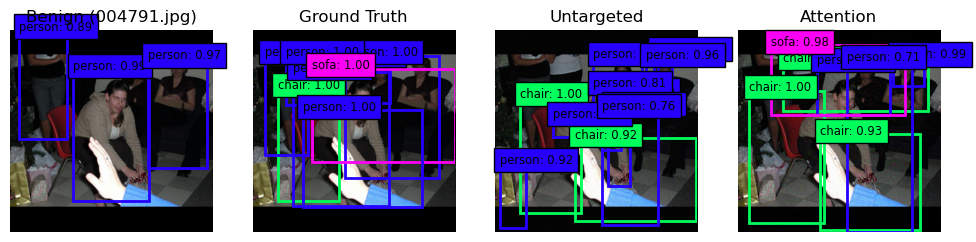

<Figure size 640x480 with 0 Axes>

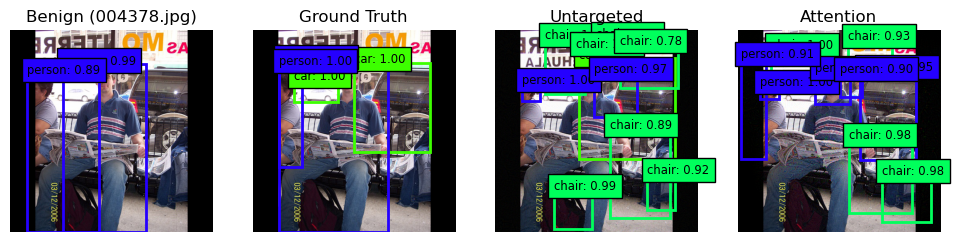

<Figure size 640x480 with 0 Axes>

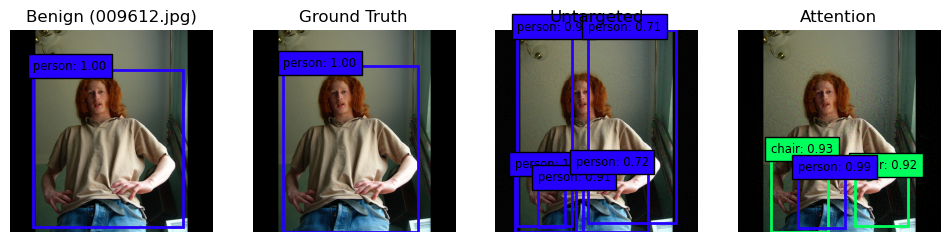

<Figure size 640x480 with 0 Axes>

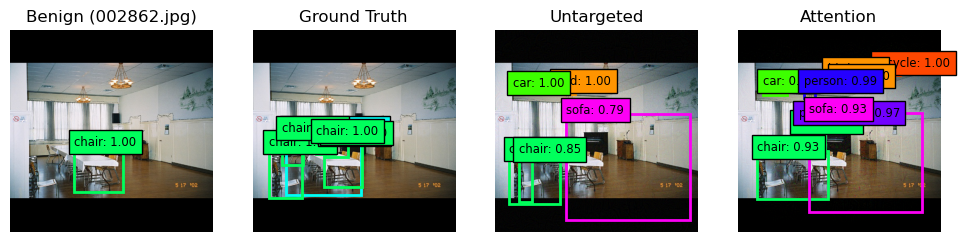

<Figure size 640x480 with 0 Axes>

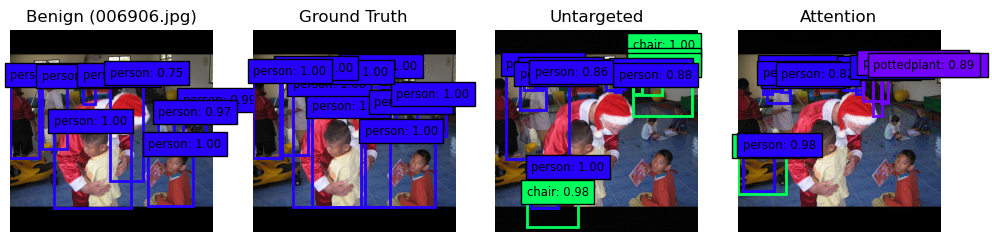

<Figure size 640x480 with 0 Axes>

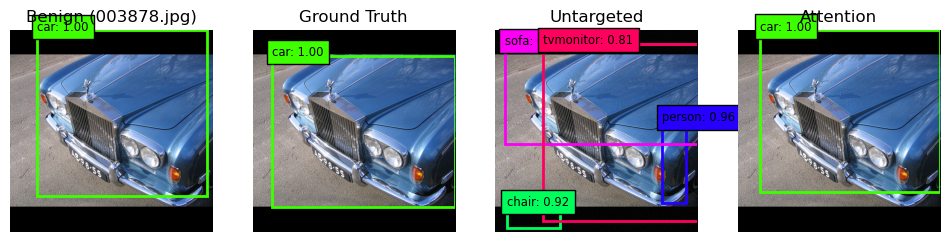

<Figure size 640x480 with 0 Axes>

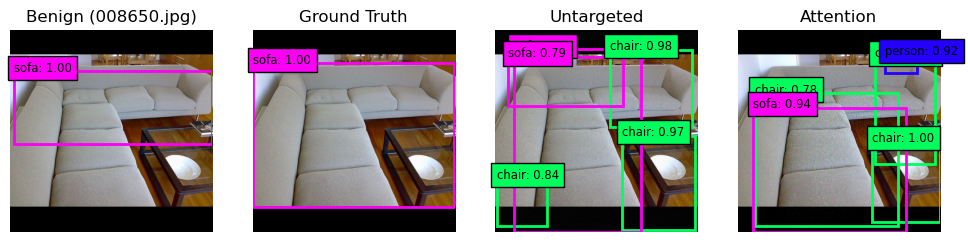

In [34]:
def visualize_fail_image(num):
    fpath = 'dataset/VOCdevkit/VOC2007/JPEGImages/'    # TODO: Change this path to the image to be attacked
    annot_path = 'dataset/VOCdevkit/VOC2007/Annotations/'

    input_img = Image.open(fpath + num)
    x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
    detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)
    
    x_adv = tog_untargeted(detector, x_query)
    detections_adv = detector.detect(x_adv, conf_threshold=detector.confidence_thresh_default)
    
    x_attn = tog_attention(detector, x_query)
    detections_attn = detector.detect(x_attn, conf_threshold=detector.confidence_thresh_default)
    
    visualize_detections({'Benign ('+str(num)+')': (x_query, detections_query, detector.model_img_size, detector.classes),
                          'Ground Truth': (x_query, get_gt_bboxes(annot_path, num, x_meta), detector.model_img_size, detector.classes),
                         'Untargeted': (x_adv, detections_adv, detector.model_img_size, detector.classes),
                          'Attention': (x_attn, detections_attn, detector.model_img_size, detector.classes)
                         })

f = open('dataset/AttackFails/attack_fails.txt')
for line in f.readlines()[:10]:
    visualize_fail_image(line.strip("\n") + ".jpg")
    


In [2]:
#im_path = 'dataset/AttackFails/FailImages/'
im_path = 'dataset/VOCdevkit/VOC2007/JPEGImages/'
annot_path = 'dataset/VOCdevkit/VOC2007/Annotations/'
# --- FULL TEST SET ---
#mAP on benign: 0.6562
# aps: [0.7044335  0.69047619 0.63014493 0.56618357 0.49875    0.77065868
#  0.66304569 0.76463023 0.56941748 0.62568306 0.6761194  0.726
#  0.74104478 0.75495868 0.61304229 0.49082278 0.56467391 0.70657895
#  0.71692913 0.64954955]

#mAP on untarget is:
# [0.33333333, 0.06113537, 0.01683938, 0.05882353, 0.06603774, 0.02857143,
#  0.03419689, 0.14285714, 0.04780876, 0.,         0.,         0.12688822,
#  0.57142857, 0.03846154, 0.01785969, 0.03166227, 0.04651163, 0.07692308,
#  0.,         0.07792208]


# --- FAIL SUBSET ---
#TOG-class got 0.03814 on first 500 images

#mAP on benign for just this dataset is 0.6559
#APs:
# [0.75       0.732      0.53461538 0.55       0.46962025 0.9
#  0.7203125  0.85384615 0.55652174 0.65       0.59130435 0.75660377
#  0.70714286 0.61111111 0.60458716 0.42173913 0.58333333 0.66785714
#  0.95       0.50666667]

#mAP on untargeted for just this dataset is 0.2401
#APs:
# aps: [0.         0.33125    0.11754386 0.         0.21958763 0.6
#  0.2254717  0.4        0.19446494 0.         0.5        0.38550725
#  0.6        0.         0.14875491 0.19245283 0.2        0.34333333
#  0.         0.34444444]
# {'map': 0.24014054502154925}

#mAP on benign for entire dataset is 

scores = evaluate_dataset(detector, im_path, annot_path, num_examples=500, attack=None)
print(scores)
#flag_induced_tp(detector, im_path, annot_path, num_examples=20, attack=tog_untargeted)

100%|██████████| 500/500 [01:38<00:00,  5.10it/s]

{'aps': array([0.66433566, 0.55892256, 0.55244755, 0.54545455, 0.38383838,
       0.74545455, 0.57575758, 0.63203463, 0.47593583, 0.37784091,
       0.58585859, 0.62545455, 0.62770563, 0.63636364, 0.54965415,
       0.43272727, 0.32844575, 0.44415584, 0.75174825, 0.63636364]), 'map': 0.5565249747294494}


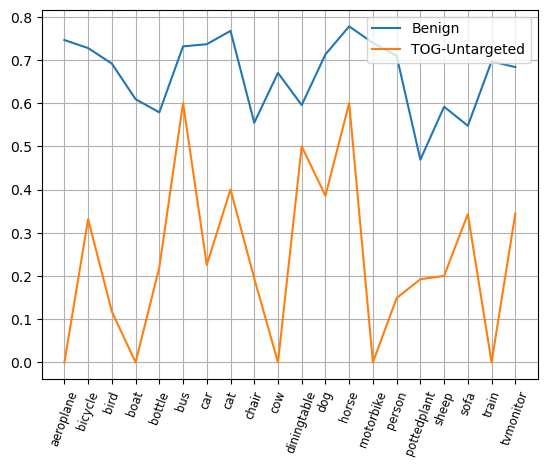

In [3]:
#Full Thing


# graph_aps({
#     "Benign": [0.7044335,  0.69047619, 0.63014493, 0.56618357, 0.49875,    0.77065868,
#                0.66304569, 0.76463023, 0.56941748, 0.62568306, 0.6761194,  0.726,
#                0.74104478, 0.75495868, 0.61304229, 0.49082278, 0.56467391, 0.70657895,
#                0.71692913, 0.64954955]
# # (untargeted class) mAP is: 0.6561571398315751,
#     "TOG-Untargeted": [0.33333333, 0.06113537, 0.01683938, 0.05882353, 0.06603774, 0.02857143,
#                       0.03419689, 0.14285714, 0.04780876, 0.,         0.,         0.12688822,
#                       0.57142857, 0.03846154, 0.01785969, 0.03166227, 0.04651163, 0.07692308,
#                       0.,         0.07792208]
# })
# Subset
graph_aps({
        "Benign":[0.74585366, 0.72727273, 0.69129213, 0.60896226, 0.57849057,
       0.7311828 , 0.73620523, 0.76708464, 0.55448852, 0.66985646,
       0.59542484, 0.71270588, 0.7775    , 0.73929961, 0.70923575,
       0.46905371, 0.59155556, 0.54752475, 0.69661654, 0.68319672],
        "TOG-Untargeted": [0.,         0.33125,    0.11754386, 0.,         0.21958763, 0.6,
                      0.2254717,  0.4,        0.19446494, 0.,         0.5,        0.38550725,
                      0.6,        0.,         0.14875491, 0.19245283, 0.2,        0.34333333,
                      0.,         0.34444444]
                      })

In [8]:
# num = "000001"
# fpath = 'dataset/VOCdevkit/VOC2007/JPEGImages/'+str(num)+'.jpg'    # TODO: Change this path to the image to be attacked
# annot_path = 'dataset/VOCdevkit/VOC2007/Annotations/'+str(num)+'.xml'

# input_img = Image.open(fpath)
# x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
# detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)
# x_adv = tog_untargeted(detector, x_query)
# detections_adv = detector.detect(x_adv, conf_threshold=detector.confidence_thresh_default)
# visualize_detections({'Benign ('+str(num)+')': (x_query, detections_query, detector.model_img_size, detector.classes),
#                       'Ground Truth': (x_query, get_gt_bboxes(annot_path, x_meta), detector.model_img_size, detector.classes),
#                      'Untargeted': (x_adv, detections_adv, detector.model_img_size, detector.classes)})

# from frcnn_utils.eval_tool import eval_detection_voc

# annot_boxes = get_gt_bboxes(annot_path, x_meta)
# pred_bboxes = detections_query[:,-4:]
# pred_labels = np.array([detections_query[:,0]])
# pred_scores = np.array([detections_query[:,1]])
# gt_bboxes = annot_boxes[:, -4:]
# gt_labels = np.array([annot_boxes[:, 0]])
# print(pred_bboxes)
# print(pred_labels)
# print(pred_scores)
# print(gt_bboxes)
# print(gt_labels)
# eval_detection_voc(pred_bboxes, pred_labels, pred_scores, gt_bboxes, gt_labels)

In [ ]:
flag_induced_tp